# Loading The Model and Packages

In [46]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
from KernelLogistic import KernelLogisticRegression
plt.style.use('seaborn-v0_8-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments

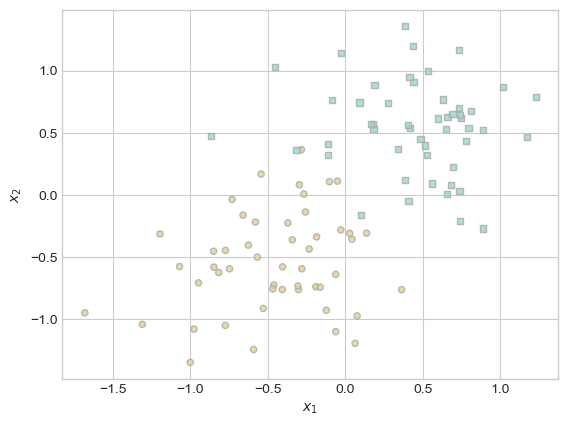

In [47]:
# Define a function to generate classification data
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y

# Define a function to plot the classification data
def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# Generate and plot roughly linearly separable data
fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

From the plot, it is clear that it this data is on the edge between linearly separable and linearly inseparable. Lets explore how Sparse Kernel Logistic Regression is able to classify these data points.

In [49]:
# first lets define a standard kernel
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

# instantiate a model with the given kernel and random parameters
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)

# Fit the data with 100000 training iterations and a reasonably small alpha
KR.fit(X, y, m_epochs = 100000, alph = 0.001)

Let's inspect the entries of the model weight vector to see if they have remained close to zero even after training.

In [53]:
# look at the mean of the weight vecctors
print("The mean of the weight vector a is: " + str((1.0*(KR.a > 0.001)).mean().item()))
print("The number of entries in a is: " + str(len(KR.a)))

The mean of the weight vector a is: 0.07000000029802322
The number of entries in a is: 100


Thus, across 100 entries in a the mean value is .07 which is remarkably close to 0. Thus, our Sparse Kernel Logisitic Regression has maintained the property of a that many entries are equal to or close to zero. Lets plot the scores along with the training data. 

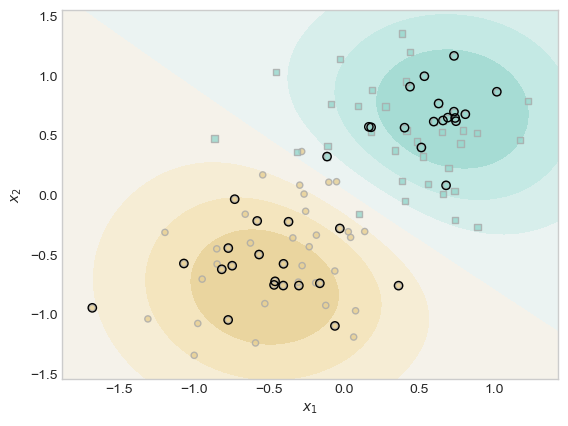

In [58]:
ix = torch.abs(KR.a).view(-1) > 1e-4

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")